**Requirements**:
- python 3.X (3.6.X, better)
- `matplotlib` 2.X : I used lots of Perceptual Uniform Sequential Colomap, `viridis` or `inferno`, which only includes in newer versions. Check the default style changes in [matplotlib2.0](https://matplotlib.org/users/dflt_style_changes.html#colormap), (everybody hate `jet`)
- `seaborn` : [Statistical data visualization](https://seaborn.pydata.org/)
- [`healpy`](https://healpy.readthedocs.io/en/latest/) : Healpix `python` module
- `Jupyter` : included in [`Anaconda`](https://www.anaconda.com/download/), but you can install [independently](http://jupyter.org/install.html) if you like
- `numpy` and `scipy` and `pandas`: included in [`Anaconda`]((https://www.anaconda.com/download/))

In [2]:
# patches' anaysis class on spheres
%run slide_helper/Pinpoint.py 
# fitting class
%run slide_helper/Shift.py    
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import itertools
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use('default')
matplotlib.rc("font", family="serif", size=14)
matplotlib.rc("figure", figsize="10, 5")
colors = ['k', 'c', 'm', 'y']
matplotlib.rc('axes', prop_cycle=cycler("color", colors))

# import modules
import numpy as np
import healpy as hp
import pandas as pd
import glob
from scipy.stats.mstats import mquantiles

# Healpy bug with BK
from matplotlib.pyplot import cm
import matplotlib.animation as animation
cmap = cm.RdYlBu_r
cmap.set_under('w')
viridis = cm.viridis.set_under('w')

from six.moves import cPickle as pickle
import matplotlib.gridspec as gridspec

# slide helper module
from slide_helper.YakitoriTakingOut import Yakitori_optimize, CartView_Block_Layer, Good_Scheme_Scores

# ignore all warnings to make the layout prettier
import warnings
warnings.filterwarnings('ignore')

# your choice for the input data
data_path    = '.'
featureMap   = '../data/fits/hist/I_20_commander_hyperlarge_unsmoothed.fits'
commanderMap = '../../Release2/Component_maps/COM_CMB_IQU-commander-field-Int_2048_R2.01_full.fits'

from ipywidgets import widgets

# Full-sky acoustic peak shifts from patches

In [2]:
# just found this thing for 3D interactive spherical viz with python
# it's not quite useful but can be used as a cover
from vpython import *

# local texture
sphere( texture={'file' : '/nbextensions/vpython_data/feature_map.jpg',} )
lamp1 = local_light(pos=vector(3,3,3), color=color.gray(0.2))
lamp2 = local_light(pos=vector(3,-3,-3), color=color.gray(0.2))

Note for MF
Outline: 
- Introduction: VPYTHON animation, Scan through the sky to see what can we get
- Data & Background 
    - Patches Selection: 
        - Randomly Placed
        - Non-overlapped
    - Peaks Shift Measurement
        - (scaling relation, FFT, SPICE) power spectrum estimation 
        - (fitting) De-noise, NPB, SPICE all together 
    - Feature Defined
- Results: Cool interactive figs here (smoothing bar)
    - Larger-scales Shifts significance
    - _X Rolling Regression regression estimates_
    - Dipole Analysis
    - SNL resampling and Hierarchical Regression
- Conclusion 

## Motivation
- **DATA MINING** in Acoustic Peaks

![](shift.gif)

- Honestly, <font color='purple'>No MORE</font>!

- We should find our motivation from data

In [3]:
# I put the animation generator here, you can play with your own
plot_gif = False

def gaussian(x, p):
    amp, mean, sigma = p
    return (amp / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- (x - mean)**2 / (2 * sigma**2))

if plot_gif == True:
    # load in Shift class to access all Peaks Shifts fitting methods and variables
    # make sure you are running the shift class in the same directory with data/Shift/*
    # Otherwise, load in data with load_txt keyword argument.
    shift = Shift(type_of_patch='square', type_of_map='smica', size=20, )

    # don't want to run too much samples, 
    for idx,dl in enumerate(shift.dls[:4]):
        # generate frames
        x = np.linspace(0, 1350, 100)

        # construct fitted function with 4 gaussians
        p1, p2, p3, p4 = [(amp, mean, sigma) 
                          for amp,mean,sigma in zip(
                              shift.df.loc[idx, 'amp1':'amp4'], 
                              shift.df.loc[idx, 'center1':'center4'],
                              shift.df.loc[idx, 'sigma1':'sigma4'])]
        peaks = shift.df.loc[idx, 'peak1':'peak3']
        y = sum((gaussian(x, p) for p in [p1, p2, p3, p4]))

        # animation generation
        fig, ax = plt.subplots()
        ell = (np.arange(len(dl)) * 360 / shift.size)
        line, = ax.plot(ell[4:], dl[4:], '.', color=colors[0])
        points, = ax.plot(peaks, [10000,10000,10000], 'o', markersize=15, color=colors[3])
        line, = ax.plot(x, y, linewidth=3, color=colors[1])
        ax.set_xlabel('$\ell$')
        ax.set_ylabel('$D_{\ell}$')    

        # peaks positions
        # I know it is kind of bad written, but anyway, just an animation
        y_peaks = np.array([y[np.argmin((x - peak) ** 2)] for peak in peaks])
        y_peaks = np.array([y_peaks - i * y_peaks / 20 for i in range(21)])

        def update(num, x, y, line, points):
            if num < len(x):
                line.set_data(x[:num], y[:num])
                line.axes.axis([0, 1350, 0, 7000])
            elif num >= len(x) and num < 2 * len(x):
                points.set_data(peaks, y_peaks[0])
                line.set_data(x[:len(x) - num], y[:len(x) - num])
                line.axes.axis([0, 1350, 0, 7000])
            else:
                points.set_data(peaks, y_peaks[num - 2 * len(x)])
            return line, points

        ani = animation.FuncAnimation(fig, update, len(x) + len(x) + 20, fargs=[x, y, line, points],
                                      interval=25, blit=True)
        ani.save('.'.join(['shift',str(idx),'gif']), writer='imagemagick')

## Quick Overview of Feature Map Making Process 

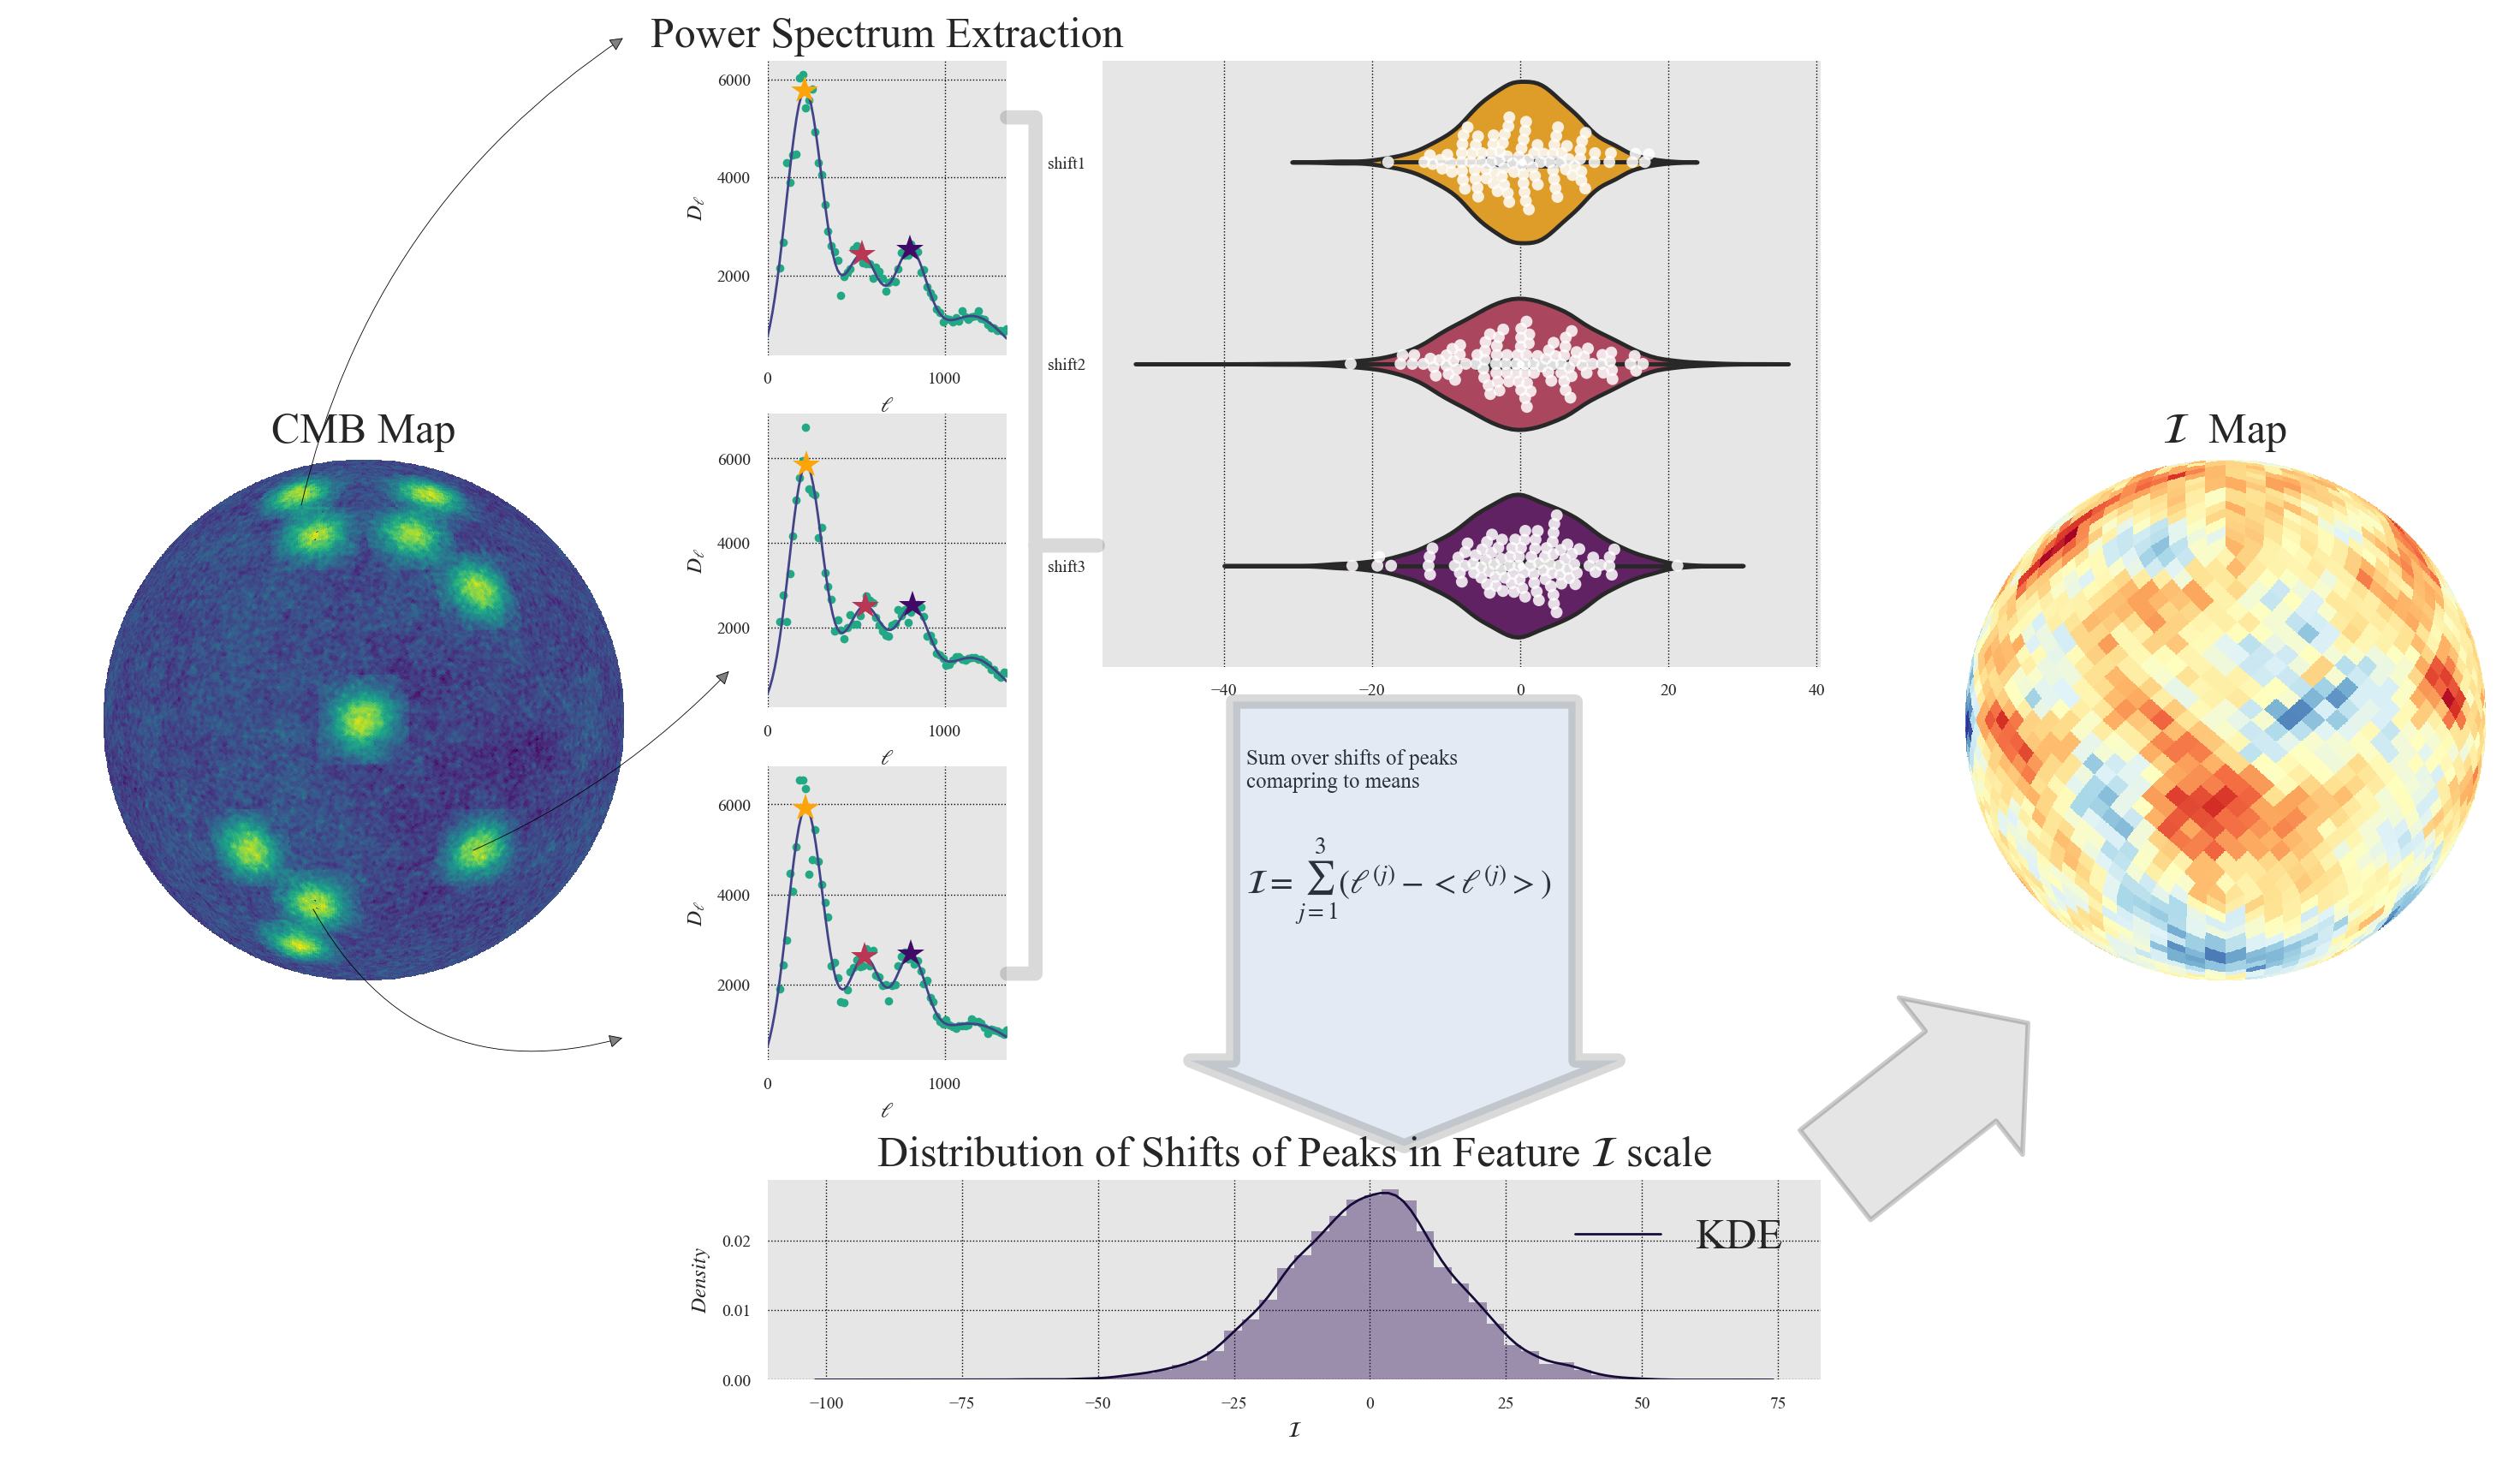

In [4]:
%run slide_helper/poster_plotting.py \
-i1 $commanderMap -i2 $featureMap -d $data_path

## How to choose Patches? <font color="gray"> Randomly Placed Patch Centers</font>
- **First Choice:** Randomly Placed

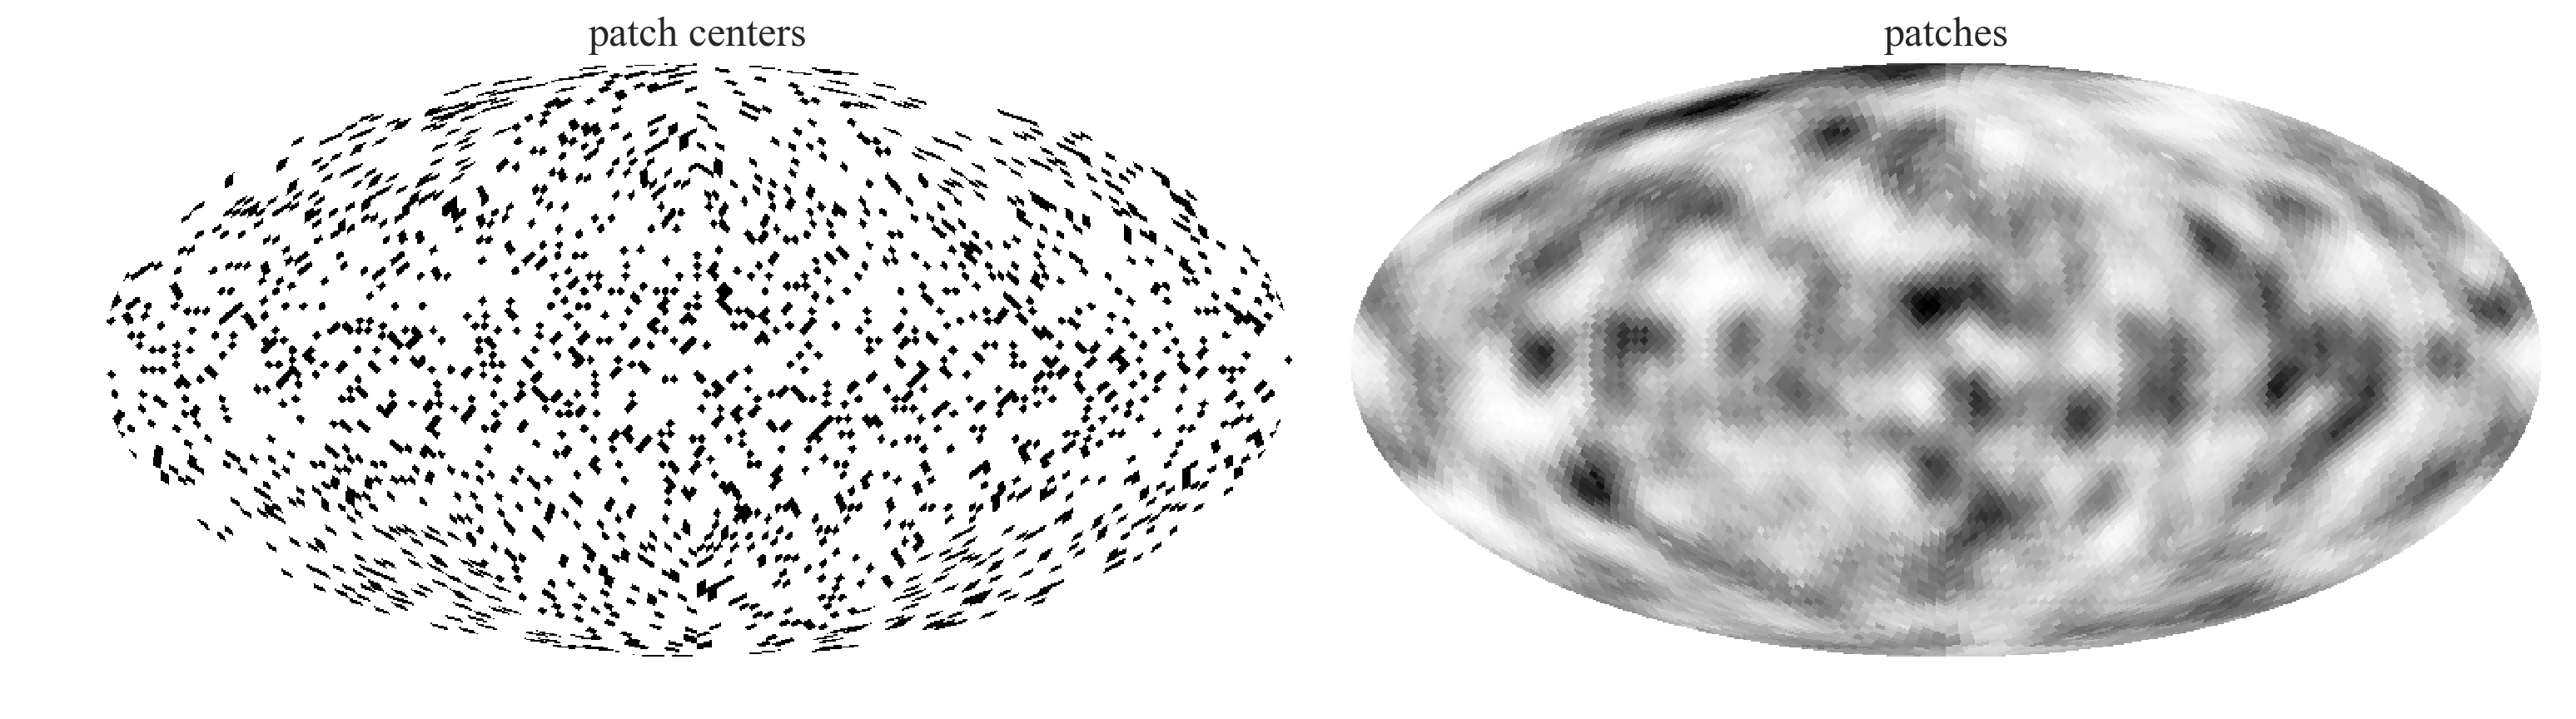

In [5]:
# This is just a demonstration of choosing randomly placed patches, 
# so I just choose an adequate amount of patches
nside = 32
num_pix = 2000

# nside=32, 1000 random pixels
healpix = np.zeros(hp.nside2npix(nside))
ipix    = np.random.choice(np.where(healpix == 0)[0], size=num_pix)
healpix[ipix] = 1

# placed patch centers on 1000 random pixels
## we are super lazy, so let's use pixel conversion to (phi, theta)
lon, lat = hp.pix2ang(nside=nside, ipix=ipix, lonlat=1)
rot   = np.array([lon, lat]).T

## use methods in Pinpoint class to stack layers of patches
pinpoint     = Pinpoint('large', 'commander', 20, data_path=data_path)
Addition_map = pinpoint.plot_scanning(coor=rot, weight=np.ones(len(rot)), xsize=1440, nside=nside)

plt.figure(figsize=(15,6))
hp.mollview(healpix,      cmap=viridis, sub=(1,2,1), title='patch centers', cbar=0)
hp.mollview(Addition_map, cmap=viridis, sub=(1,2,2), title='patches',       cbar=0)

- **Pros:** 
    - minimize the variance of peaks measurement by large amount of overlapping patches.
    - uniform distributed on a sphere.
- **Cons:**
    - slow

- (Hidden) **Pros**: 
    - eligible to train on convolutional neural network (ideally, we can train a CNN to replace our peak position extraction process, so we can speed up the program)

## How to choose Patches? <font color="gray"> Avoid Overlapping </font>
- **Second Choice:** Non-Overlapped Patches
- **Strategy:** taking out overlapped patches <font color="blue">(the tricky part is how to setup the initial scheme)</font>  
and try to keep <font color='purple'>$N_{coverage}-N_{overlapped}$</font> as high as possible.  
![](output.gif)

- But, honestly, *you can easily broke my "taking out program"*. My program does not work very well for too small sizes (< 10) and consumes too much time to take out. 
- Moreover, we still have to choose rotation $\theta$ manually. (I choose to optimize  <font color='purple'>$N_{coverage}-N_{overlapped}$</font> )

<font color='blue'>$\Rightarrow$ I am happy to hear any suggestion to build a real algorithm.<font color='blue'>

Goodness of this Scheme is 0.734619140625
********..............................................................................Good_Scheme_Scores is 0.7054036458333334


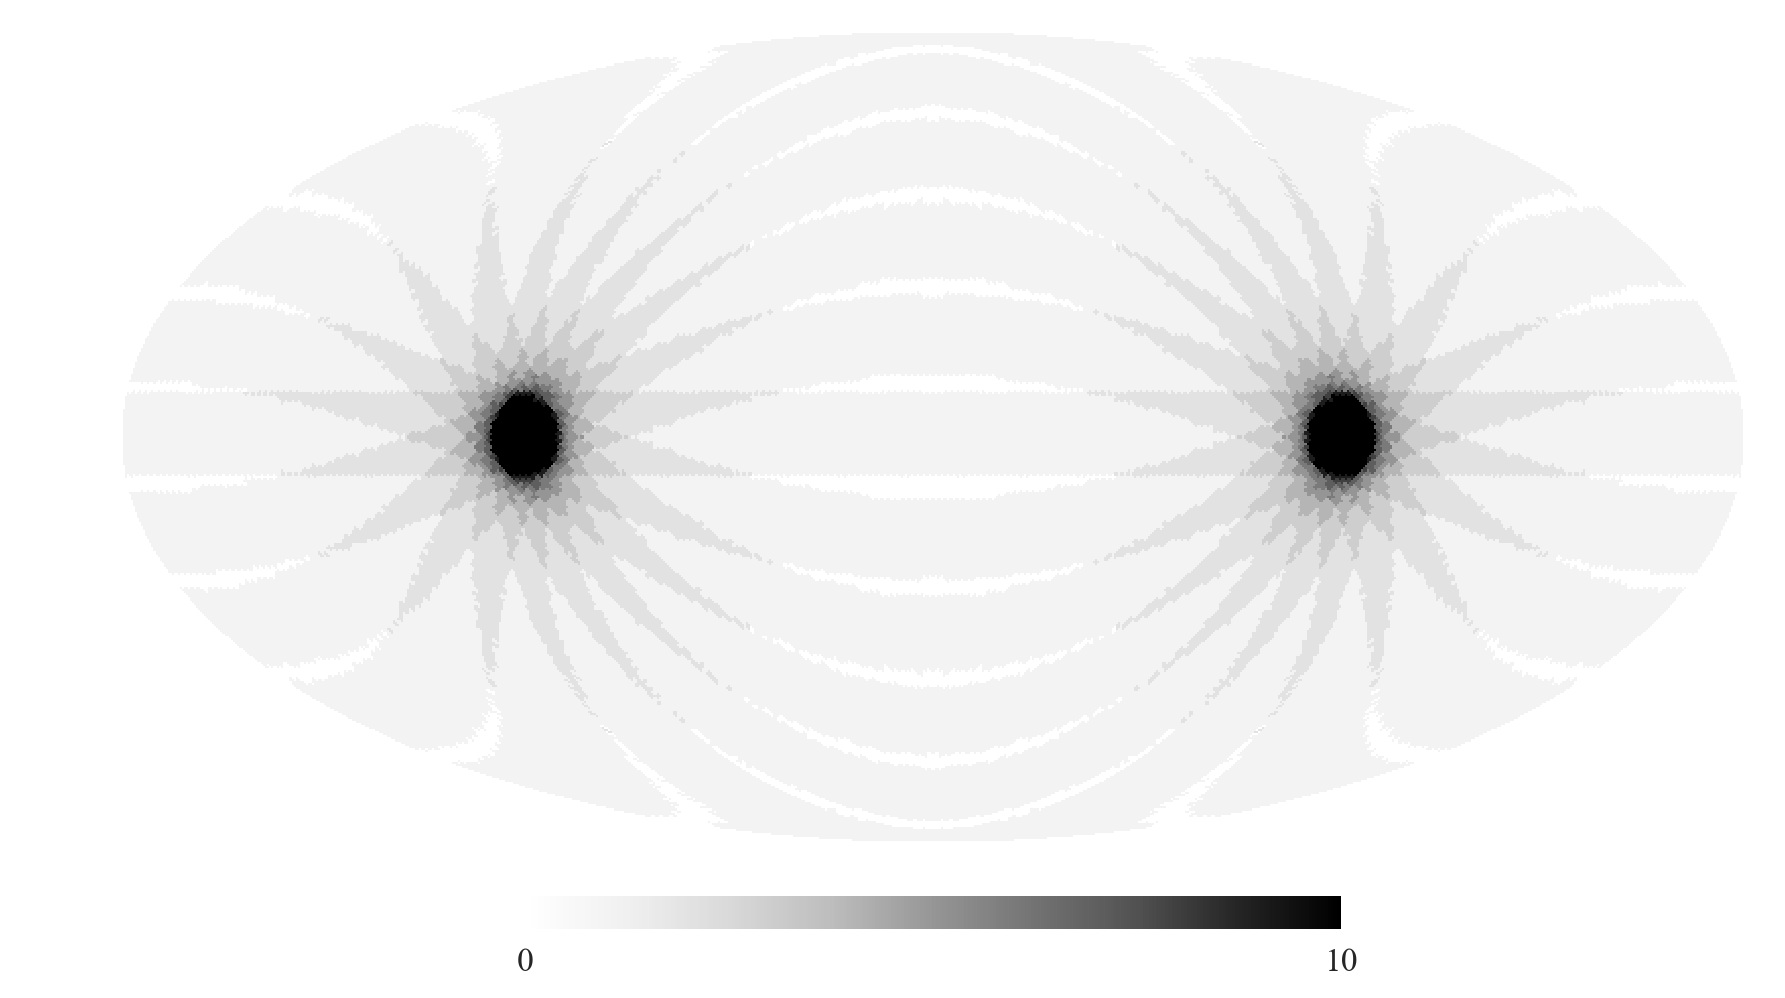

In [6]:
# I put my "taking out patches program" here, 
# I wrote it a long time ago, 
# so hope you will not blame me about the readability.
# TODO: make it prettier and make them to be a class

## Somehow the result will fluctuate with the choice 
## of Patch_Size and NSIDE, that is because the reslution of image
MK = False
PHI_RANGE   = 15
THETA_RANGE = 18
NSIDE       = 64 
PATCH_SIZE  = 100  

period = 180 // THETA_RANGE
Layers = []
Theta_List = np.arange(period) * THETA_RANGE
for theta in Theta_List:
    Layer = CartView_Block_Layer(
        theta, PHI_RANGE, NSIDE, patch_size=PATCH_SIZE)     
    for A in Layer: Layers.append(A)
    del Layer

# make it a numpy tensor, with shape = (num_of_layers, npix_of_healpix)
Layers = np.array(Layers)
Addition_map = np.sum(Layers, axis=0)
print('Goodness of this Scheme is {}'.format(Good_Scheme_Scores(Addition_map)))

# Brute loop for optimization
opt_Layers = Yakitori_optimize(Layers, THETA_RANGE, PHI_RANGE, Mask=MK, snap=0)
hp.mollview(Addition_map, title='',) # plot figs

- **Pros:** 
    - eligible to calculate the p-value for each patch
    - do not have to deal with miss-fitted problem
- **Cons:**
    - hard to interpret in statistics
    - my program is not perfect

- (Hidden) **Pros**: 
    - it is an interesting problem! $\rightarrow$ how do you select squares on a sphere with least overlapping areas?

And, for the situation of non-square but equal area, we already got _**`Healpix`**_ <font color="blue">(Hierarchical Equal Area Iso Latitude pixelation of the sphere)</font>! so you might notice I provide a method to do <font color="purple">CNN on spheres</font> in my <font color="purple">thesis appendix</font> by using the hierarchical equal area properties of `Healpix`.

## Peak Shifts Feature Maps  
- peak shift features:
    - $\mathcal{D}$: The distance $\mathcal{D}_i$ represents how far the peaks of patch $i$ deviated from the mean.
    - $\mathcal{I}$: The sign of $\mathcal{I}$ indicates the direction of peaks shift, e.g., the peaks (statistically) lean synchronously toward smaller $\ell$ (larger scales) if the $\mathcal{I}_i$ returned a large negative value for the $i$th patch.

$$\begin{equation}
\mathcal{I}_i = \sum\limits_{j = 1}^3 ({\ell_i}^{(j)} - \bar \ell^{(j)}),
\end{equation}$$

$$\begin{equation}
  \mathcal{D}_i = \sqrt{\sum\limits_{j = 1}^3 {({\ell_i}^{(j)} - \bar \ell^{(j) })^2}},
\end{equation}$$

where $\bar \ell^{(j)} $ is the mean of the $j$th peak positions from the ensemble. 

## A Peak-Shift Feature Map: <font color="gray"> Define a Feature for Shifts of Peaks </font>
- peak-shift features:
    - $\mathcal{I}$: The sign of $\mathcal{I}$ indicates the direction of peaks shift, e.g., the peaks (statistically) lean synchronously toward smaller $\ell$ (larger scales) if the $\mathcal{I}_i$ returned a large negative value for the $i$th patch.

$$\begin{equation}
\mathcal{I}_i = \sum\limits_{j = 1}^3 ({\ell_i}^{(j)} - \bar \ell^{(j)}),
\end{equation}$$

where $\bar \ell^{(j)} $ is the mean of the $j$th peak positions from the ensemble. 


- Of course, features are not limited with only one kind, but let us focus on direction of shifts in this talk.

## A Peak-Shift Feature Map: <font color="gray"> Why call it <font color="purple">**"Feature Map"**</font>?</font>



- Option 1: I like it.

- Option 2: In computer vision, we can use a filter to detect a feature on a given image. The output activations of the filter is called a <font color="purple">**feature map**</font>.
![](mylenet.png)  
(source: LeNet)


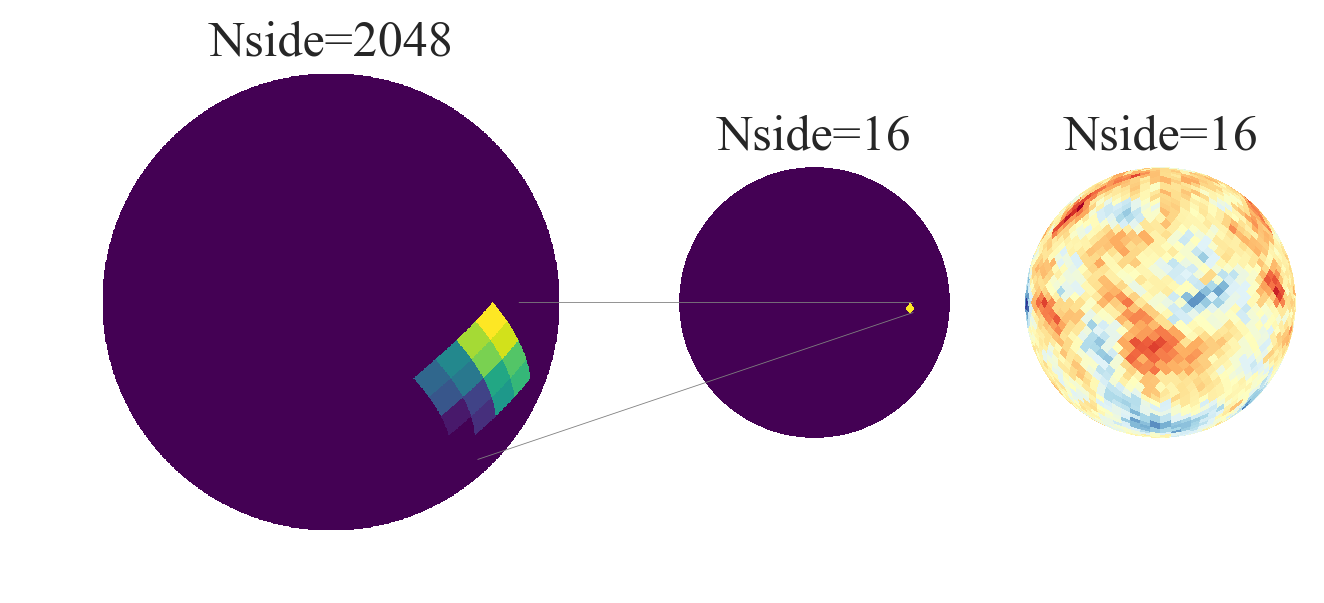

In [12]:
# Filter on Healpix
plt.figure(figsize=(8, 3))
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[4, 2, 2,], ) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# haven't find a better way to interact between healpy and axes
plt.axes(ax0)
hp.orthview(np.arange(hp.nside2npix(8)), cmap=cm.viridis,
            nest=1, cbar=0, title='Nside=2048', half_sky=1, sub=(1,4,1), min=752, hold=1)
plt.axes(ax1)
hp.orthview(np.arange(hp.nside2npix(16)), cmap=cm.viridis,
            nest=1, cbar=0, title='Nside=16', half_sky=1, sub=(1,4,2), min=3070, hold=1)
plt.annotate("", xycoords='axes fraction',
            xy=(0.88, 0.47), 
            xytext=(-0.75, -0.08), 
            arrowprops=dict(arrowstyle='-', color='gray',)
            )
plt.annotate("", xycoords='axes fraction',
            xy=(0.88, 0.5), 
            xytext=(-0.6, 0.5), 
            arrowprops=dict(arrowstyle='-', color='gray',)
            )

plt.axes(ax2)
I = hp.read_map('../data/fits/hist/I_20_commander_hyperlarge_unsmoothed.fits', verbose=0)
hp.orthview(I, cbar=0, title='Nside=16', half_sky=1, sub=(1,4,3), cmap=cmap, hold=1)

## A Peak-Shift Feature Map: <font color="gray"> Why call it <font color="purple">**"Feature Map"**</font>?</font>

- <font color="blue">A pixel on a feature map</font> is the output (activation) of **linear or non-linear operations** from a <font color="purple">small image (filter)</font> in the original image.
    1. > <font color=""gray>A feature map</font> is obtained by **repeated application of a function across sub-regions** of the entire image   (quote, [Lenet](http://deeplearning.net/tutorial/lenet.html)) 
    2. > Feature Maps = features and their locations (quote, [ICCV 2015](https://courses.engr.illinois.edu/ece420/sp2017/iccv2015_tutorial_convolutional_feature_maps_kaiminghe.pdf))

In [15]:
# loading MNIST image data
from keras.datasets import mnist

# loading MNIST
(xtrain, _), (_, _) = mnist.load_data()
xtrain = xtrain / 255  

def plotFilter(number, filter_idx):
    plt.clf();plt.close()
    # Chooise a filter
    Filters = [np.array( [[1,-1,], [1,-1,]] ), 
               np.array( [[1,1,],  [-1,-1]]), 
               np.array( [[1,-1,], [-1,1,]] )]
    Filter = np.kron(Filters[filter_idx], np.ones((4,4))) # expand size
    Image  = xtrain[2 * number + 1]

    # Activation or Feature map
    row, col = Filter.shape
    Activation = np.zeros((Image.shape[0] - row + 1, Image.shape[1] - col + 1))
    for x in range(Activation.shape[0]):
        for y in range(Activation.shape[1]):
            Activation[x,y] = (Image[x:x + row, y:y + col] * Filter).sum()

    Activation[abs(Activation) < 16] = 0
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(Filter, cmap=cm.viridis)
    ax[0].set_title(f'Filter {filter_idx}')
    ax[1].imshow(Image, cmap=cm.viridis)
    ax[1].set_title(f'Image {idx}')
    ax[2].imshow(Activation, vmax=16, vmin=-16, cmap='RdBu')
    ax[2].set_title('Feature Map \n(or Activations)')
    plt.show();

In [16]:
# A Conv Layer : Making a Filter Map
# | Filter (8 x 8) | Image (28 x 28) | Activation (21 x 21)| 
dropdown = widgets.Dropdown(
    options=[0, 1, 2],
    value=0,
    description='filter:',
    disabled=False,
)
widgets.interact(plotFilter, number=range(10), filter_idx=dropdown);

## A Peak-Shift Feature Map: <font color="gray"> Map Making </font>

- Map making: we smooth peak-shift feature using `Healpix` pixels.

In [10]:
# Map Making process plotting function, 
# based on the steps for random choosing 
def plotMakingMapProcess(step):
    plt.close(); plt.clf()
    # randomly sample points on sphere
    healpixPts = np.zeros(hp.nside2npix(32))
    ipix = hp.ang2pix(nside=32, 
                      theta=pinpoint.rot[:step,0], 
                      phi=pinpoint.rot[:step,1], lonlat=1)
    for pix in ipix:
        healpixPts[ipix] += 1

    # feature maps appending
    healpix = np.zeros(len(I))
    ipix = hp.ang2pix(nside=hp.npix2nside(len(I)), 
                      theta=pinpoint.rot[:step,0], 
                      phi=pinpoint.rot[:step,1], lonlat=1)
    shiftDict = dict() 
    for i,pix in enumerate(ipix):
        if pix in shiftDict:
            shiftDict[pix].append(pinpoint.df.shift_sum[i])
        else:
            shiftDict[pix] = []
            shiftDict[pix].append(pinpoint.df.shift_sum[i])
    for pix in ipix:
        healpix[pix] = np.mean(shiftDict[pix])

    hp.mollview(healpixPts, cbar=0, title='Patch Centers', sub=(1,2,1))
    hp.mollview(healpix, title='$\mathcal{I}$ Feature Map', cmap=cmap, sub=(1,2,2), max=50, min=-50)
    plt.show()

In [11]:
# map making process, slider 
## |patch plot_scanning | Healpix map making|
widgets.interact(plotMakingMapProcess, step=(1, 10000))

<function __main__.plotMakingMapProcess>

In [ ]:
# make a hp.mollview which have options to choose to display
## Dropdown : commander 20 18 15, smica 20, fitting powell 20, SPICE
## | mollview (select) | mollview (select)|

## Shifts of Peaks toward Larger Scales

- Consistent with Chiang (2017)
- A Spot near Draco

/Users/cicero/anaconda/envs/viper/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


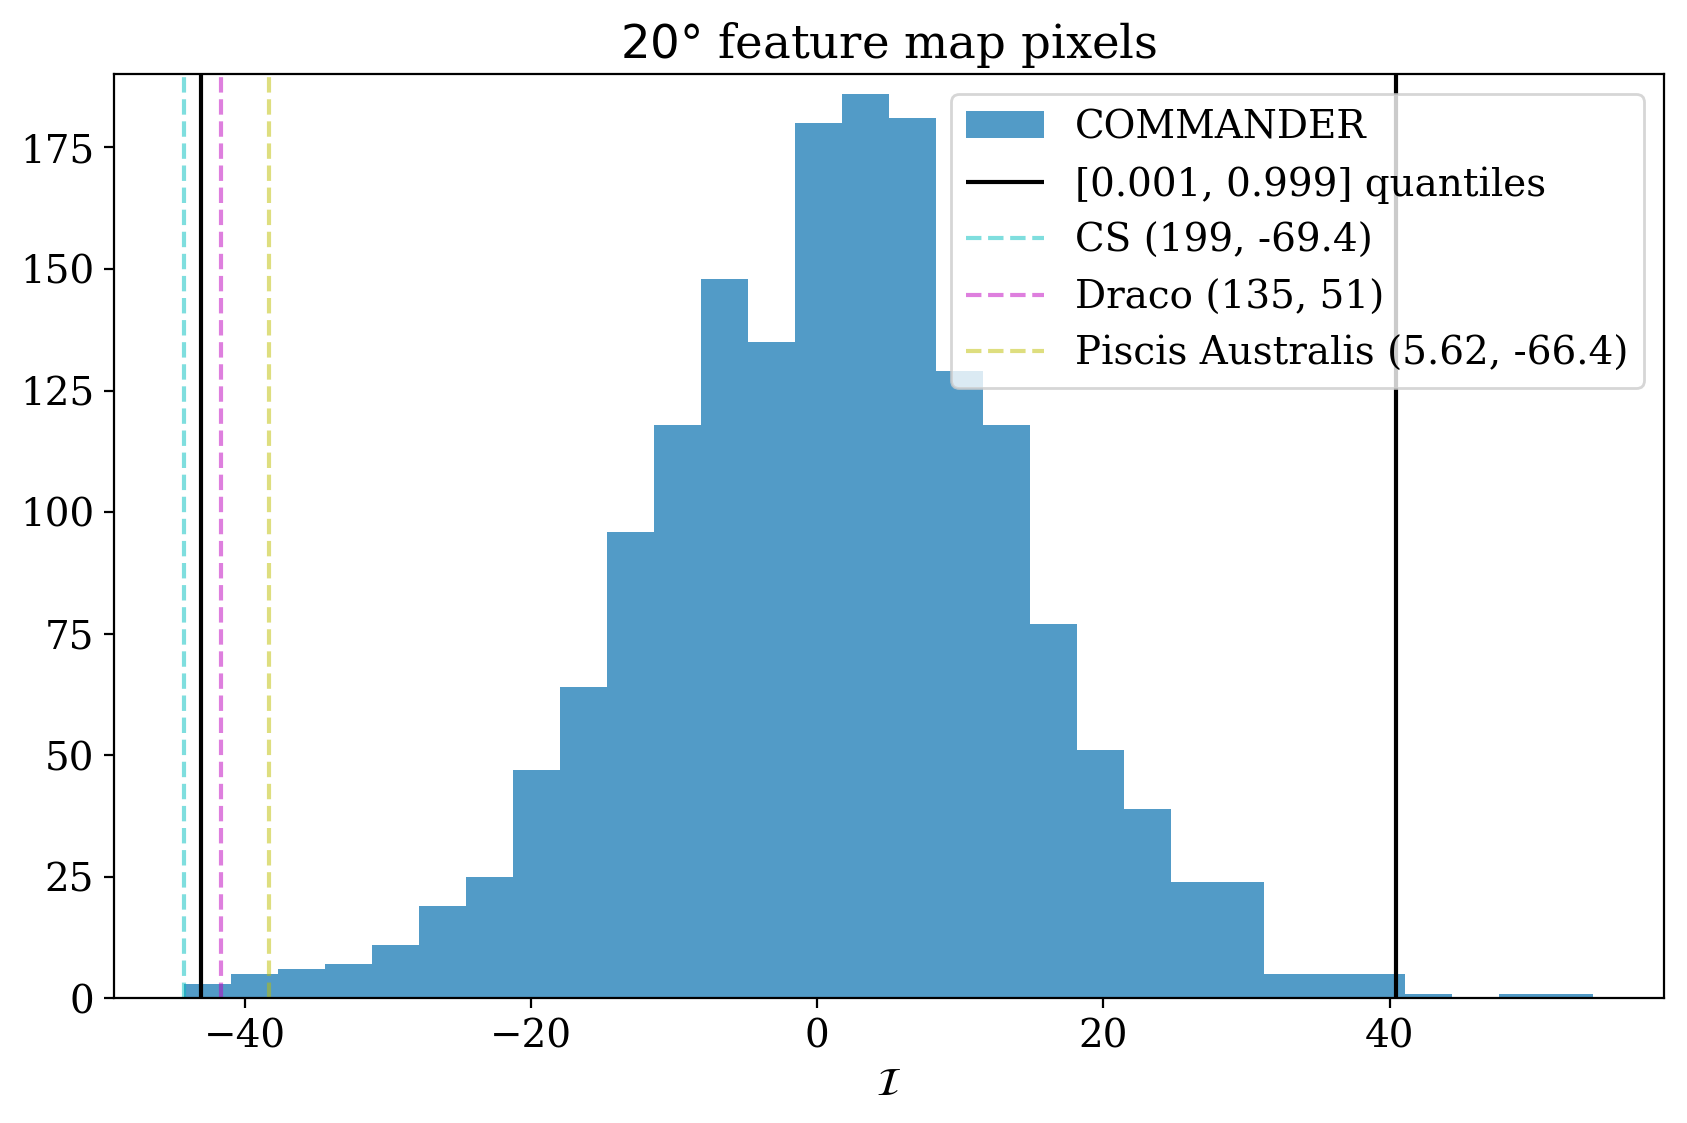

In [19]:
# Hist (| feature map select a pixel | shown a vertical line in histogram  |)
I = hp.read_map('../data/fits/hist/I_20_commander_hyperlarge_unsmoothed.fits', verbose=0)
Mask = hp.read_map('../../Release2/HFI_Mask_GalPlane-apo0_2048_R2.00.fits', field=2, verbose=0)
mask = hp.ud_grade(Mask, nside_out=16)

# all pixels w or without masking 
nside  = 16
length = 3072
map_mask_pix = np.where((1 - mask) == 0)[0]

# get simulations samples for quantiles
files = glob.glob('../data/fits/hyperhist/I_.20.*')
lenesd_centers = np.array([
    hp.read_map(file, verbose=0) for file in files]).ravel()

# get smica samples for histogram
comm_centers = I[map_mask_pix]

# compute quantiles from simulations feature maps
qs = mquantiles(lenesd_centers, prob=[0.001, 0.5, 0.999])

# generate figure canvas
plt.figure(figsize=(10, 6))
plt.hist(comm_centers, histtype="stepfilled", 
         normed=0, alpha=0.85, bins=30, stacked=1,
         label="COMMANDER", 
         color="#348ABD", )
plt.vlines([qs[0], qs[-1]], [0, 0], [200, 200], alpha=1, colors='k', label='[0.001, 0.999] quantiles')
plt.vlines(I[map_mask_pix[np.argsort(comm_centers)[0]]], 0, 200, alpha=0.5, linestyles='dashed', color=colors[1], label='CS (199, -69.4)')
plt.vlines(I[map_mask_pix[np.argsort(comm_centers)[1]]], 0, 200, alpha=0.5, linestyles='dashed', color=colors[2], label='Draco (135, 51)')
plt.vlines(I[map_mask_pix[np.argsort(comm_centers)[4]]], 0, 200, alpha=0.5, linestyles='dashed', color=colors[3], label='Piscis Australis (5.62, -66.4)')
plt.ylim(0, 190)
plt.xlabel('$\mathcal{I}$')
plt.title('$20\degree$ feature map pixels')
plt.legend();

In [46]:
lon, lat = hp.pix2ang(ipix=np.arange(hp.nside2npix(16)), lonlat=1, nside=16)
I_int = (I_int - I_int.min()) 
I_int = ((I_int / I_int.max()) - 0.5) * 2
df = pd.DataFrame(dict(glon=360 - lon, glat=lat, value=I_int))
df.to_csv('/Users/cicero/Documents/Physics/JS/D3/example/Healpix/data.csv')

## Multipole Expansion: Larger Dipole Power 
- **Where is the dipole direction?**
$$\begin{equation}
v_x^{(1,1)} = -\sqrt{2} a_{1,1}^{re}, v_y^{(1,1)} = \sqrt{2} a_{1,1}^{im}, v_z = a_{1,0}, 
\end{equation}$$
(Copi et al. (2004))
